#前言


本篇筆記將會簡單介紹`Keras`套件的各種基本功能，並且實際示範如何訓練一個簡單的模型。
本篇會介紹的基本功能如下：
* 如何 Import Keras
* 建立模型
* 訓練模型
* 使用模型進行預測
* 載入/儲存模型

本篇筆記要訓練的問題如下：
<br/>
> 有一藥廠開發了一種藥物，經測試後發現此藥物對於13~65歲的人有5%發生副作用，但對65歲以上的人有95%發生副作用，我們要訓練一個模型去預測給定某個年齡的受試者會不會發生副作用</br>

> |   | 發生副作用 |  未發生副作用 |   
> |---|---|---|
> | 13~65歲(younger) | 5%  |  95% |
> | 65歲以上(older)  | 95%  | 5%  |











# Import

為了要讓我們能夠方便地進行模型訓練，我們需要`import`以下套件(package)，其中最重要的就是**tensorflow**以及其中的**keras**，能讓我們直觀且快速的建立模型並訓練。這邊的程式碼並不需要特別記憶，如果忘記`import`的話程式會自動報錯，提醒你要`import`什麼套件。

In [1]:

from random import randint
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler


In [3]:
# 最基本的幾個套件，基本上一定要import
import numpy as np
import tensorflow as tf
from tensorflow import keras

# 跟「繪圖」有關的套件，如果沒有打算繪圖就不用 import
%matplotlib inline
import matplotlib.pyplot as plt


# 跟「設計模型」有關的套件，如果沒有要設計或是修改模型的話就不用 import
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# 跟「編譯(compile)模型」有關的套件
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

# 跟「混淆矩陣(confusion matrix)」有關的套件
from sklearn.metrics import confusion_matrix
import itertools


為了加快訓練速度，我們使用GPU進行加速。<br/>
執行本行之前先至工具列中的 **`執行階段` > `變更執行階段類型` > `硬體加速器選擇GPU` > `儲存`**


In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(" Number of GPUs available: " , len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

 Number of GPUs available:  1


# 好用的函式

## show_train_history( train_history )


* 用途：繪製 accuracy 和 loss 的曲線，可以用來比較 train set 和
 validation set 的差距（如果 train set 的 accuracy 遠高於 validation set，就表示有overfitting 的情況）
 
* 參數：
  * `train_history`：直接把 `model.fit()` 回傳的 `train_history` 丟進來就可以顯示了
  * 任何 Keras Sequential 的模型都能用這個函數

In [5]:
def show_train_history(train_history):

  fig , ax = plt.subplots()
  fig.subplots_adjust(hspace=0.4, wspace=0.4) #設定子圖的間隔
  fig.set_figwidth(14)

  ax1 = plt.subplot(1, 2, 1)
  plt.title("Accuracy")
  plt.plot(train_history.history['accuracy'],'-', label='accuracy')
  plt.plot(train_history.history['val_accuracy'],'-',  label='val_accuracy')
  leg = ax1.legend(loc='lower right') 
  plt.ylabel('accuracy')
  plt.xlabel('Epoch')


  ax2 = plt.subplot(1, 2, 2)
  plt.title("Loss")
  plt.plot(train_history.history['loss'],'-', label='loss')
  plt.plot(train_history.history['val_loss'],'-', label='val_loss')
  leg = ax2.legend(loc='upper right') 
  plt.ylabel('loss')
  plt.xlabel('Epoch')
  plt.show()

# 產生訓練用的資料
為了要訓練模型我們必須要準備足夠的樣本(samples)以及相對應的標籤(labels)，通常這些訓練用的資料庫都會從外部載入，但因為這個題目比較簡單，我們可以自己模擬生成樣本。

先建立兩個陣列分別儲存標籤(labels)和樣本(samples)

In [15]:
x_train = [] # input
y_train = [] # expected output

進行以下操作：<br/>

|   | 發生副作用（標記為1） |  未發生副作用（標記為0） |   
|---|---|---|
| 13~65歲(younger) | 50人  |  950人 |
| 65歲以上(older)  | 950人  |  50人  |

In [16]:
for i in range(50):
  
  random_younger = randint(13,64)
  x_train.append(random_younger)
  y_train.append(1)

  random_older = randint(65,100)
  x_train.append(random_older)
  y_train.append(0)

for i in range(950):
  
  random_younger = randint(13,64)
  x_train.append(random_younger)
  y_train.append(0)

  random_older = randint(65,100)
  x_train.append(random_older)
  y_train.append(1)


檢查一下生成的數據

In [ ]:
for i in range(1000):
  print('編號：' + str(i) + '  年齡：'+ str(x_train[i]) + '  副作用：' + str(y_train[i]))

# 資料預處理（Preprocessing）
機器學習其中一個很重要的步驟就是整理收集到的樣本資料，這樣才能保證不同資料格式進到模型前可以統一格式和範圍，避免產生過大的偏差。

把原本的陣列(array)轉換成 numpy array 並打亂順序
> 'shuffle' 即為英文的洗牌之意 

> 關於`shuffle`函數可參見：https://numpy.org/doc/stable/reference/random/generated/numpy.random.shuffle.html

In [18]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train, y_train = shuffle(x_train, y_train)


使用`reshape`把每個資料都變成一個陣列，以符合模型輸入的格式

In [ ]:
x_train = x_train.reshape(-1,1)


for i in x_train:
  print(i)


使用`MinMaxScaler`把資料(13\~100歲)縮放到0~1的範圍內
> 關於`MinMaxScaler`可參見: https://blog.csdn.net/weixin_40683253/article/details/81508321

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
x_train_scaled = scaler.fit_transform(x_train)


for i in x_train_scaled:
  print(i)


In [21]:
print(y_train.shape)
print(x_train_scaled.shape)

(2000,)
(2000, 1)


In [14]:
print(x_train_scaled)

[[0.93103448]
 [0.59770115]
 [0.35632184]
 ...
 [0.66666667]
 [0.31034483]
 [0.66666667]]


# 建立模型

機器學習最重要的一個步驟就是建立一個好的模型，接下來我們可以看到如何具體地把不同layers組合成一個模型，並進行訓練。

`model`即為我們要訓練的模型，使用`Sequential`函數可以非常直觀地設計模型的樣子，我們的模型詳細結構如下：<br/>

|  層數 |  Layer名稱 |  Unit(channel)數量 |  激勵函數(activation function) |
|---|---|---|---|
|  第一層 | Dense(Full Connect)  | 16  |  relu |
| 第二層  | Dense(Full Connect)   | 32  |  relu |
|  第三層 | Dense(Full Connect)   |  2 |  softmax |

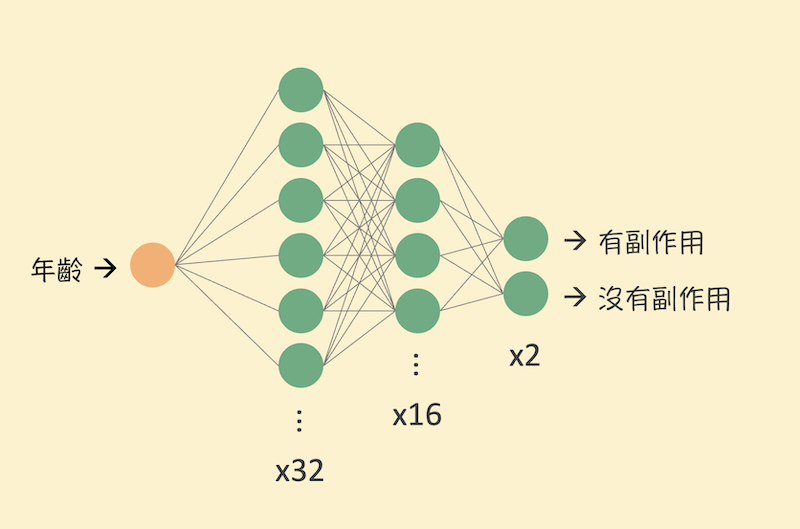

In [22]:
model = Sequential([
  Dense(units=16, input_shape=(1,), activation='relu'),
  Dense(units=32, activation='relu'),
  Dense(units=2, activation='softmax')         
])

使用`summary`查看模型的詳細內容

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                32        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 642
Trainable params: 642
Non-trainable params: 0
_________________________________________________________________


tensorflow還有一種非常圖像化的查看模型方式

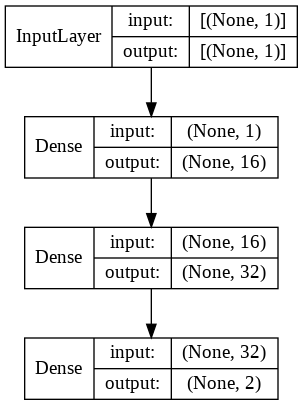

In [24]:
tf.keras.utils.plot_model(
    model,
    show_shapes = True,
    show_layer_names = False
)

# 訓練模型

對模型進行編譯（compile）

In [25]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

使用`fit`函數開始訓練模型，我們將`validation_split`設為`0.1`，也就是說每一次訓練的時候有十分之一的資料會被拿來測試模型的預測準確度`val_accuracy`。<br/><br/>
**如果模型發生overfit，`val_accuracy`會比`accuracy`低很多。**


In [26]:
train_history = model.fit(x=x_train_scaled, y=y_train, validation_split=0.1,  batch_size=10, epochs=30, verbose=1)

Epoch 1/30
180/180 [==============================] - 3s 3ms/step - loss: 0.6534 - accuracy: 0.5433 - val_loss: 0.6328 - val_accuracy: 0.6250
Epoch 2/30
180/180 [==============================] - 0s 2ms/step - loss: 0.6253 - accuracy: 0.6244 - val_loss: 0.6064 - val_accuracy: 0.6950
Epoch 3/30
180/180 [==============================] - 0s 2ms/step - loss: 0.6000 - accuracy: 0.6778 - val_loss: 0.5822 - val_accuracy: 0.7250
Epoch 4/30
180/180 [==============================] - 0s 2ms/step - loss: 0.5753 - accuracy: 0.7150 - val_loss: 0.5594 - val_accuracy: 0.7350
Epoch 5/30
180/180 [==============================] - 0s 2ms/step - loss: 0.5498 - accuracy: 0.7644 - val_loss: 0.5358 - val_accuracy: 0.7750
Epoch 6/30
180/180 [==============================] - 0s 3ms/step - loss: 0.5236 - accuracy: 0.7822 - val_loss: 0.5129 - val_accuracy: 0.7950
Epoch 7/30
180/180 [==============================] - 0s 3ms/step - loss: 0.4967 - accuracy: 0.8178 - val_loss: 0.4896 - val_accuracy: 0.8000
Epoch 

查看訓練過程

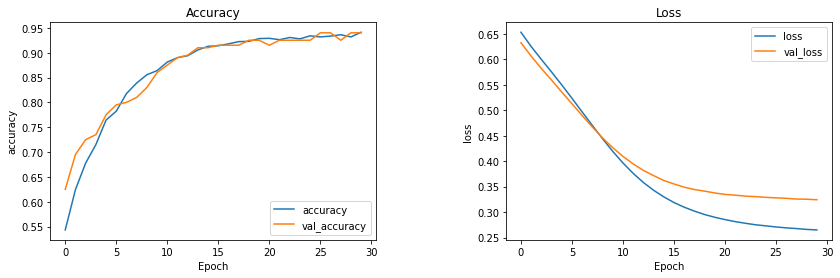

In [27]:
show_train_history(train_history)

# 建立測試樣本

我們要評估一個模型是不是能準確的預測結果，除了使用`validation_split`之外，也可以另外找一組測試資料，讓模型進行預測`prediction`



建立測試用的資料`test_samples`和`test_labels`：<br/>

|   | 發生副作用（標記為1） |  未發生副作用（標記為0） |   
|---|---|---|
| 13~65歲(younger) | 10人  |  190人 |
| 65歲以上(older)  | 190人  |  10人  |

In [28]:
y_test =  []
x_test = []

for i in range(10):
    # The 5% of younger individuals who did experience side effects
    random_younger = randint(13,64)
    x_test.append(random_younger)
    y_test.append(1)

    # The 5% of older individuals who did not experience side effects
    random_older = randint(65,100)
    x_test.append(random_older)
    y_test.append(0)

for i in range(190):
    # The 95% of younger individuals who did not experience side effects
    random_younger = randint(13,64)
    x_test.append(random_younger)
    y_test.append(0)

    # The 95% of older individuals who did experience side effects
    random_older = randint(65,100)
    x_test.append(random_older)
    y_test.append(1)



我們一樣要對測試資料進行預處理（preprocess）

In [29]:
y_test = np.array(y_test)
x_test = np.array(x_test)
y_test, x_test = shuffle(y_test, x_test)

x_test_scaled = scaler.fit_transform(x_test.reshape(-1,1))

# 測試模型

我們要使用`x_test`和`y_test`來測試模型，因為這些資料並不是剛剛訓練時使用的資料，因此我們可以確認模型並不是直接把答案背起來，而是真正掌握到數據的特徵。

In [31]:
score = model.evaluate(x_test_scaled, y_test)
print('測試分數：', score[0])
print('測試準確率：', score[1]*100, '%')

13/13 [==============================] - 0s 3ms/step - loss: 0.3054 - accuracy: 0.9425
測試分數： 0.30536580085754395
測試準確率： 94.24999952316284 %


# 使用訓練好的模型進行預測

接下來我們來練習如何讓模型進行預測，通常我們把模型練好之後，就會把模型移到其他程式裡面，來完成我們想達成的功能（像是圖形辨識，資料分析等）


要使用模型進行預測，我們要用`predict`函數

In [32]:
predictions = model.predict(x=x_test_scaled, batch_size=10, verbose=0)

In [ ]:
for i in predictions:
  print(i)

把結果四捨五入（0.5以上視為「有副作用」，0.5以下視為「沒有副作用」

In [39]:
rounded_predictions = np.argmax(predictions, axis = -1)

檢視結果

In [ ]:
for i in range(len(rounded_predictions)):
  print("編號：" + str(i) + "  年齡：" + str(x_test[i])  +  "  預測結果：" + str(rounded_predictions[i]) + "  實際結果：" + str(y_test[i]))

In [41]:
wrong_cases = 0
for i in range(len(rounded_predictions)):
  if rounded_predictions[i] != y_test[i]:
    wrong_cases += 1

print('錯誤數量：' + str(wrong_cases))
print("測試數量：" + str(len(rounded_predictions)))
print( '錯誤率：' + str( wrong_cases / len(rounded_predictions) *100) + '%')
print( '正確率：' + str(100 - wrong_cases / len(rounded_predictions) *100) + '%')

錯誤數量：23
測試數量：400
錯誤率：5.75%
正確率：94.25%


# 載入/儲存模型

我們把模型訓練好之後，通常會希望在其他的程式使用它，因此我們需要把模型的參數和結構存下來，這樣之後就可以直接使用，不用再訓練一次。

### 儲存模型

In [42]:
import os.path
if os.path.isfile('models/medical_trial_model.h5') is False:
  model.save('models/medical_trial_model.h5')

此時去畫面左邊的資料夾標籤中查看，應該會發現多一個`models`資料夾，裡面有一個`medical_trial_model.h5`檔案

### 載入模型

In [43]:
from tensorflow.keras.models import load_model
new_model = load_model('models/medical_trial_model.h5')

檢視載入的模型（應該要跟儲存的一樣）

In [44]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                32        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 642
Trainable params: 642
Non-trainable params: 0
_________________________________________________________________


查看模型的參數

In [45]:
new_model.get_weights()

[array([[-0.38217098,  0.3362036 ,  0.58119017,  0.03417935,  0.32455376,
          0.44537565, -0.05262835, -0.09638932, -0.34362233, -0.23886096,
          0.60218114,  0.04159022, -0.4742874 , -0.30525044,  0.6527042 ,
          0.51401   ]], dtype=float32),
 array([ 0.        , -0.10819016, -0.10794889,  0.23789641, -0.10520383,
        -0.05147351,  0.22712944,  0.        ,  0.        ,  0.        ,
        -0.14456663,  0.20923428,  0.        ,  0.        , -0.11429209,
        -0.11332838], dtype=float32),
 array([[ 0.1419945 , -0.03745791, -0.1714849 ,  0.0145238 , -0.2391493 ,
          0.10093606,  0.09706655,  0.30474904, -0.02848235, -0.13199052,
         -0.22670554, -0.2614149 , -0.24125993,  0.02400449,  0.02301344,
          0.25397208, -0.24737392,  0.32297722,  0.0516583 , -0.1355602 ,
         -0.16303927,  0.19536868,  0.3470402 ,  0.12837872,  0.05250561,
         -0.13116613,  0.28686604,  0.17209175,  0.29987016,  0.16374633,
          0.03789937,  0.00354937],
 

查看模型的optimizer（應該跟儲存的模型一樣）

In [46]:
new_model.optimizer